dataset:https://drive.google.com/drive/folders/16q5ELgtQxo_6QrbFIEZtgl8m9M9rj6zP?usp=sharing

detaset comes from:https://www.kaggle.com/datasets/gti-upm/leapgestrecog?select=leapGestRecog

## Group Name:Sword New New<br/>
## Group Project:  Handgesture <br/>
Group Member:<br/>
Guangyuan Ma<br/>
Mingrui Ding<br/>
Xiao Chu<br/>
Haotian Luo<br/>
Yuchuan Deng<br/>

## Introduction
The gesture recognition database is a collection of near-infrared images of ten different gestures. In this notebook, we use deep learning and machine learning to build classifiers for these images.


## Problem State
How to accurately identify which gesture is in the presence of background information interference and classify it correctly.

Load Data

In [39]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader,random_split



In [41]:
def isodata_threshold(image):
    gray_image = image
    # get a random threshold
    threshold = np.random.randint(50, 150)

    while True:
        # calculate the mean of background and foreground
        background_pixels = gray_image[gray_image <= threshold]
        foreground_pixels = gray_image[gray_image > threshold]

        if len(background_pixels) == 0 or len(foreground_pixels) == 0:
            break

        background_mean = np.mean(background_pixels)
        foreground_mean = np.mean(foreground_pixels)

        new_threshold = (background_mean + foreground_mean) / 2

        if abs(new_threshold - threshold) < 0.1:
            break
        else:
            threshold = new_threshold

    output_image = np.zeros_like(gray_image)
    output_image[gray_image > threshold] = 255
    return output_image, threshold

def preprosess(image):
 
    image = np.array(image)

    binary_image = isodata_threshold(image)[0]

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
    binary_image2 = isodata_threshold(gray_image)[0]

    contours, _ = cv2.findContours(binary_image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
       
        max_contour = max(contours, key=cv2.contourArea)
 
        x, y, w, h = cv2.boundingRect(max_contour)
        output_image = binary_image[y:y + h, x:x + w]
        output_image = cv2.resize(output_image, (80, 80))
    return output_image

current path:  c:\Users\wudus\Desktop\project


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class to index {'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, 'leapGestRecog': 10}


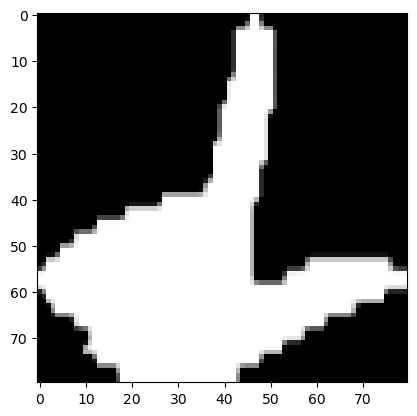

In [43]:
device = "cuda"
train_data_root = "./leapGestRecog"
current_path = os.getcwd()
print("current path: ", current_path)
data_root = os.path.join(current_path, train_data_root)


data_transform = transforms.Compose([
    transforms.Resize((48, 128)),
    transforms.Lambda(lambda img: preprosess(img)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(root=train_data_root, transform=data_transform)

train_ratio = 0.8
test_ratio = 1 - train_ratio

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
class_to_idx = dataset.class_to_idx
print("class to index", class_to_idx)

batch_size = 32
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


for images, paths in test_data_loader:
    plt.imshow(images[1].numpy().transpose(1, 2, 0))
    plt.show()
    break

full connect layer

In [8]:
class NetFull(nn.Module):
    def __init__(self):
        super(NetFull, self).__init__()
        hidden_num = 1000
        self.fc1 = nn.Linear(18432, hidden_num)
        self.fc2 = nn.Linear(hidden_num, 10)
    def forward(self, x):
        x = x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = nn.functional.tanh(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x 

convolutional neural network

In [9]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
     
        conv_hidden_num = 32
        linear_hidden_num = 64
        self.conv1 = nn.Conv2d(3,conv_hidden_num,5,3)
        self.conv2 = nn.Conv2d(conv_hidden_num,256,7,3)
        
        self.fc1 = nn.Linear(9216,linear_hidden_num)
        self.fc2 = nn.Linear(linear_hidden_num,10)
    def forward(self, x):
        
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x,dim=1)
        return x 

run full and cnn model

In [10]:
net = NetFull().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

 # loop over the dataset multiple times
running_loss = 0.0
for epoch in range(1):

    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print every 100 mini-batches
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0


print('Finished Training')

correct = 0
total = 0
# creat a new matrix to store the number of each class
conf_matrix = np.zeros((10,10),dtype=int)

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # update the matrix
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print(conf_matrix)

[1,   100] loss: 178.033
[1,   200] loss: 115.372
[1,   300] loss: 92.022
Finished Training
Accuracy of the network on the test images: 75 %
[[ 756  123   40   16    6   29    6    4    1    7]
 [   0  917   45    5    0    1    0    0    8    2]
 [   0   32  820   17   75    0    6   18   16    9]
 [   6    0   98  739    0   20    0    0   99   31]
 [   0    0  172    0  837    0    0    0    0    0]
 [   0   45  357   87   15  460    0    7   24    0]
 [   7   70  146  118  109    6  411   23  112    3]
 [   0    0    0    6    0    0    0  884  142    0]
 [   6    0   54  129    0    1    0   48  729    0]
 [   0    0    0    0    0    0    0    0    0 1040]]


In [11]:
net = NetCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

 # loop over the dataset multiple times
running_loss = 0.0
for epoch in range(3):

    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print every 100 mini-batches
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0


print('Finished Training')

correct = 0
total = 0
# creat a new matrix to store the number of each class
conf_matrix = np.zeros((10,10),dtype=int)

with torch.no_grad():
    for data in test_data_loader:
        
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # update the matrix
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print(conf_matrix)

[1,   100] loss: 228.289
[1,   200] loss: 216.420
[1,   300] loss: 182.910
[2,   100] loss: 158.500
[2,   200] loss: 104.229
[2,   300] loss: 78.241
[3,   100] loss: 61.920
[3,   200] loss: 37.867
[3,   300] loss: 26.543
Finished Training
Accuracy of the network on the test images: 92 %
[[ 936   28    0    3    0    2   16    3    0    0]
 [  13  965    0    0    0    0    0    0    0    0]
 [   9   47  669  110   37   87    9   11    2   12]
 [   0    0    8  869    0   36    2    2   70    6]
 [   0    0    0    0  989    1   12    0    1    6]
 [   0   41    0    0    6  939    2    7    0    0]
 [   0    0    0    0    0    0 1001    4    0    0]
 [   0    0    0    0    0    0    0 1032    0    0]
 [   0    0    0    4    0    1    0  103  859    0]
 [   0    0    0    0    0    0    0    0    0 1040]]


Alexnet model

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


run Alexmodel

In [18]:
net = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

 # loop over the dataset multiple times
running_loss = 0.0
for epoch in range(13):
    outputs = []
    targets = []
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = net(images)
        targets.append(labels)
        outputs.append(output)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print every 100 mini-batches
        if i % 100 == 99:
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0
    # calculate the accuracy
    outputs = torch.cat(outputs, dim=0)
    targets = torch.cat(targets, dim=0)
    _, predicted = torch.max(outputs.data, 1)
    correct = predicted.eq(targets.view_as(predicted)).sum().item()
    print('Accuracy of the network on the train images: %d %%' % (100 * correct / len(train_dataset)))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
            
        
    

print('Finished Training')
correct = 0
total = 0
# creat a new matrix to store the number of each class
conf_matrix = np.zeros((10,10),dtype=int)

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # update the matrix
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print(conf_matrix)

[1,   100] loss: 615.815
[1,   200] loss: 247.764
[1,   300] loss: 240.083
Accuracy of the network on the train images: 9 %
Accuracy of the network on the test images: 10 %
[2,   100] loss: 267.169
[2,   200] loss: 235.379
[2,   300] loss: 234.649
Accuracy of the network on the train images: 10 %
Accuracy of the network on the test images: 9 %
[3,   100] loss: 264.322
[3,   200] loss: 233.553
[3,   300] loss: 233.598
Accuracy of the network on the train images: 10 %
Accuracy of the network on the test images: 11 %
[4,   100] loss: 262.806
[4,   200] loss: 230.756
[4,   300] loss: 229.753
Accuracy of the network on the train images: 12 %
Accuracy of the network on the test images: 15 %
[5,   100] loss: 252.041
[5,   200] loss: 212.669
[5,   300] loss: 205.564
Accuracy of the network on the train images: 19 %
Accuracy of the network on the test images: 24 %
[6,   100] loss: 216.695
[6,   200] loss: 172.821
[6,   300] loss: 152.576
Accuracy of the network on the train images: 36 %
Accurac

Machine learing

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
(20000, 48, 128)
(20000, 1)
[9] [0]
Before reduction (20000, 6144)
After reduction (20000, 15)
test_acc: 0.91725
train_acc: 0.9343125
F1 Score: 0.9166566958770497


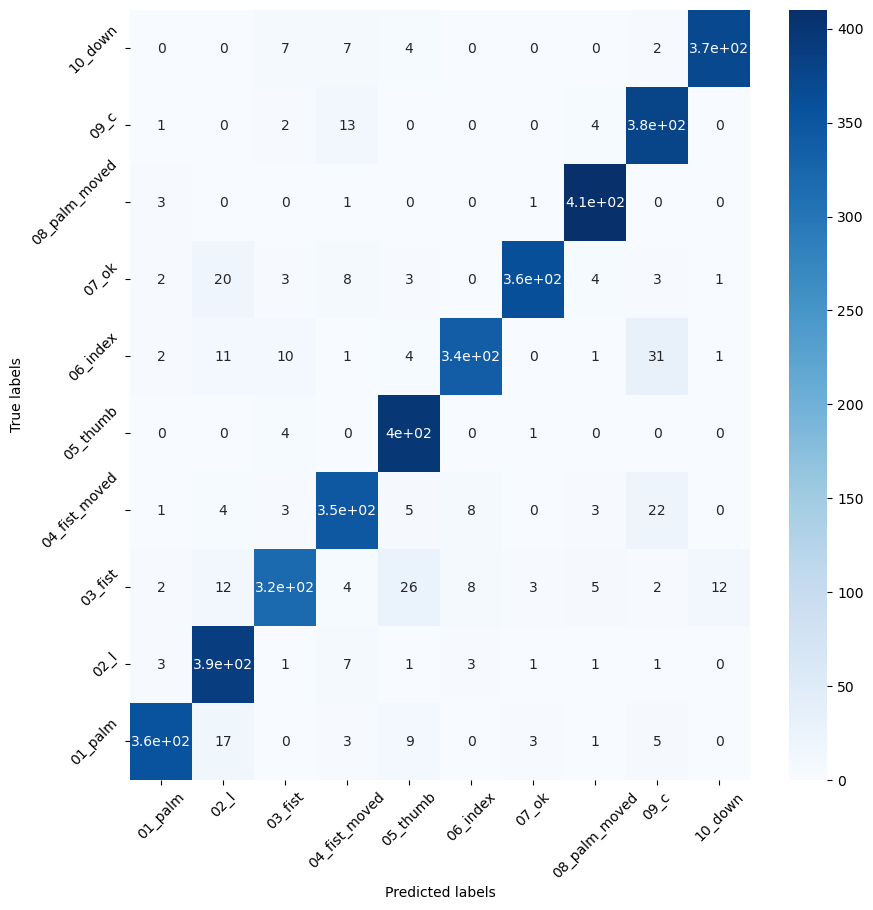

In [19]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader,random_split

root_dir = 'leapGestRecog'
class_name=sorted(os.listdir(root_dir+'/'+'00'))
print(class_name)
def build_dataset(root_dir,class_name):
    ### load data
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_name)}
    subjects_names = sorted(os.listdir(root_dir))
    x_list = []
    y_list = []
    for subjects_name in subjects_names:
            subjects_name_dir = os.path.join(root_dir, subjects_name)
            gestures = sorted(os.listdir(subjects_name_dir))
            for gesture_name in gestures:
                gesture_dir = os.path.join(subjects_name_dir, gesture_name)
                images = [img for img in os.listdir(gesture_dir) if img.endswith('.png')]
                for img_name in images:
                    img_path = os.path.join(gesture_dir, img_name)
                    label = class_to_idx[gesture_name]
                    img = cv2.imread(img_path,0)
                    img=cv2.resize(img,(int(128),int(48)))
                    _, imgf = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                    imgf=np.asarray(imgf,dtype=np.float64)
                    x_list.append(imgf)
                    y_list.append(int(label))
    num_samples = len(y_list)
    data_x=np.array(x_list)
    data_y=np.array(y_list)
    data_y= data_y.reshape(num_samples, 1)
    print(data_x.shape)
    print(data_y.shape)
    print(max(data_y),min(data_y))
    #### reshape and pre-processing of x
    data_x = data_x.reshape((num_samples, 128, 48, 1))
    data_x /= 255
    data_x=list(data_x)
    for i in range(num_samples):
        data_x[i]=data_x[i].flatten()
    data_x=np.array(data_x)
    print("Before reduction",data_x.shape)

    #### PCA dimension reduction
    reducer_PCA = PCA(n_components=15)
    data_x=reducer_PCA.fit_transform(data_x)
    print("After reduction",data_x.shape)

    #### Scale X

    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
    #### split x and y
    x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,test_size = 0.2,random_state = 45)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = build_dataset(root_dir,class_name)

model = RandomForestClassifier(n_estimators=15,max_depth=7,n_jobs=-1)
model.fit(x_train,y_train.ravel())
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print("test_acc:",test_acc)
print("train_acc:",train_acc)

y_pred = model.predict(x_test)

####  F1 Score
f1 = f1_score(y_test, y_pred, average='macro')

print("F1 Score:", f1)

predicted_labels = model.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.ylim(0, 10)
plt.xlim(0, 10)
tick_positions = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
plt.xticks(tick_positions, class_name, rotation=45)
plt.yticks(tick_positions, class_name, rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plt.savefig('confusion_forest.png', dpi=200, bbox_inches='tight')
plt.close()

Resnet model

In [37]:
def isodata_threshold(image):
    gray_image = image
    # get a random threshold
    threshold = np.random.randint(50, 150)

    while True:
        # calculate the mean of background and foreground
        background_pixels = gray_image[gray_image <= threshold]
        foreground_pixels = gray_image[gray_image > threshold]

        if len(background_pixels) == 0 or len(foreground_pixels) == 0:
            break

        background_mean = np.mean(background_pixels)
        foreground_mean = np.mean(foreground_pixels)

        new_threshold = (background_mean + foreground_mean) / 2

        if abs(new_threshold - threshold) < 0.1:
            break
        else:
            threshold = new_threshold

    output_image = np.zeros_like(gray_image)
    output_image[gray_image > threshold] = 255
    return output_image, threshold

def preprosess(image):
    # convert to numpy array
    image = np.array(image)
    # binary image with three channels
    binary_image = isodata_threshold(image)[0]
    # image to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # binary image with one channel
    binary_image2 = isodata_threshold(gray_image)[0]
    # get the contours
    contours, _ = cv2.findContours(binary_image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        # get the contour
        max_contour = max(contours, key=cv2.contourArea)
        # get the image
        x, y, w, h = cv2.boundingRect(max_contour)
        output_image = binary_image2[y:y + h, x:x + w]
        # resize
        output_image = cv2.resize(output_image, (80, 80))
    return output_image

def build_dataset(root_dir, class_name):
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_name)}
    subjects_names = sorted(os.listdir(root_dir))
    x_list = []
    y_list = []
    for subjects_name in subjects_names:
        subjects_name_dir = os.path.join(root_dir, subjects_name)
        gestures = sorted(os.listdir(subjects_name_dir))
        for gesture_name in gestures:
            gesture_dir = os.path.join(subjects_name_dir, gesture_name)
            images = [img for img in os.listdir(gesture_dir) if img.endswith('.png')]
            for img_name in images:
                img_path = os.path.join(gesture_dir, img_name)
                label = class_to_idx[gesture_name]
                img = cv2.imread(img_path)
                imgf = preprosess(img)
                imgf = np.asarray(imgf, dtype=np.float32)
                imgf = np.stack((imgf,) * 3, axis=-1)
                x_list.append(imgf)
                y_list.append(int(label))
    num_samples = len(y_list)
    data_x = np.array(x_list)
    data_y = np.array(y_list)
    data_y = data_y.reshape(num_samples)
    data_x /= 255
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)
    return x_train, x_test, y_train, y_test


class GestureDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

x_train, x_test, y_train, y_test = build_dataset(root_dir, class_name)

# Convert numpy arrays to PyTorch tensors and transpose the images
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2)
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

# Normalize the data
x_train = normalize(x_train)
x_test = normalize(x_test)

# Define datasets and data loaders
train_dataset = GestureDataset(x_train, y_train)
test_dataset = GestureDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

c:\Users\wudus\miniconda3\envs\Curry\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wudus\miniconda3\envs\Curry\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 train accuracy: 98.26875
Epoch 0 test accuracy: 99.725


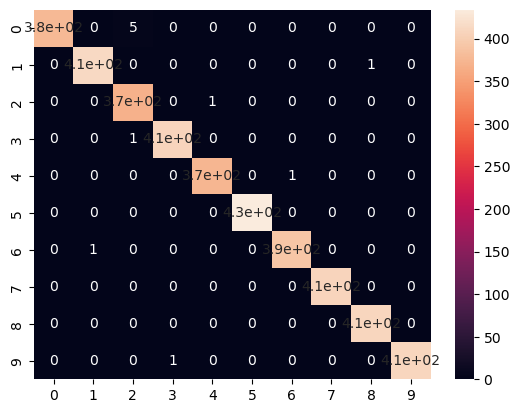

In [38]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_ftrs = 512

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(num_ftrs, len(class_name))
model.to(device)

criterion = nn.CrossEntropyLoss()
criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1):
    total = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()  # Convert labels to Long
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch {epoch} train accuracy: {train_acc}")

    with torch.no_grad():
      total = 0
      correct = 0
      all_labels = []
      all_predictions = []
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device).long()
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          all_labels.extend(labels.cpu().numpy())
          all_predictions.extend(predicted.cpu().numpy())
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      test_acc = 100 * correct / total
      print(f"Epoch {epoch} test accuracy: {test_acc}")

      cm = confusion_matrix(all_labels, all_predictions)
      sns.heatmap(cm, annot=True)
      plt.show()